In [71]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [72]:
df = pd.read_csv("first_bus_dir_1.csv")

In [73]:
import random

df['decisive_speed'] = df.apply(lambda row, weight =  random.uniform(0.8, 0.9):(row['speed_kmh'] * weight + row['segment_max_speed_kmh'] * (1 - weight)), axis=1)

In [74]:
conditions = [
    (df['decisive_speed'] > 40),
    (df['decisive_speed'] > 30),
    (df['decisive_speed'] > 20),
    (df['decisive_speed'] > 15)
]

congestion_levels = [0, 1, 2, 3]

# Use np.select to create the new 'congestion_level' column
df['congestion_level'] = pd.np.select(conditions, congestion_levels, default=4)

C:\Users\vinhn\AppData\Local\Temp\ipykernel_22508\1848422047.py:11: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df['congestion_level'] = pd.np.select(conditions, congestion_levels, default=4)


In [75]:
df['arrival_time'] = pd.to_datetime(df['arrival_time'])

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trip_id                43 non-null     object        
 1   start_stop_id          43 non-null     int64         
 2   arrival_time           43 non-null     datetime64[ns]
 3   stop_sequence_x        43 non-null     int64         
 4   stop_lat               43 non-null     float64       
 5   stop_lon               43 non-null     float64       
 6   route_id               43 non-null     int64         
 7   direction_id           43 non-null     int64         
 8   speed_kmh              43 non-null     float64       
 9   segment_max_speed_kmh  43 non-null     int64         
 10  runtime_sec            43 non-null     int64         
 11  end_stop_id            43 non-null     int64         
 12  decisive_speed         43 non-null     float64       
 13  congest

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 4.3994 - val_loss: 3.1143
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 4.2444 - val_loss: 3.0008
Epoch 3/50
1/1 [==============================] - 0s 25ms/step - loss: 4.1159 - val_loss: 2.8993
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 4.0094 - val_loss: 2.8039
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 3.9066 - val_loss: 2.7049
Epoch 6/50
1/1 [==============================] - 0s 26ms/step - loss: 3.8023 - val_loss: 2.6020
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 3.6928 - val_loss: 2.4934
Epoch 8/50
1/1 [==============================] - 0s 25ms/step - loss: 3.5761 - val_loss: 2.3769
Epoch 9/50
1/1 [==============================] - 0s 22ms/step - loss: 3.4516 - val_loss: 2.2511
Epoch 10/50
1/1 [==============================] - 0s 23ms/step - loss: 3.3198 - val_loss: 2.1167
Epoch 11/50
1/1 [==============

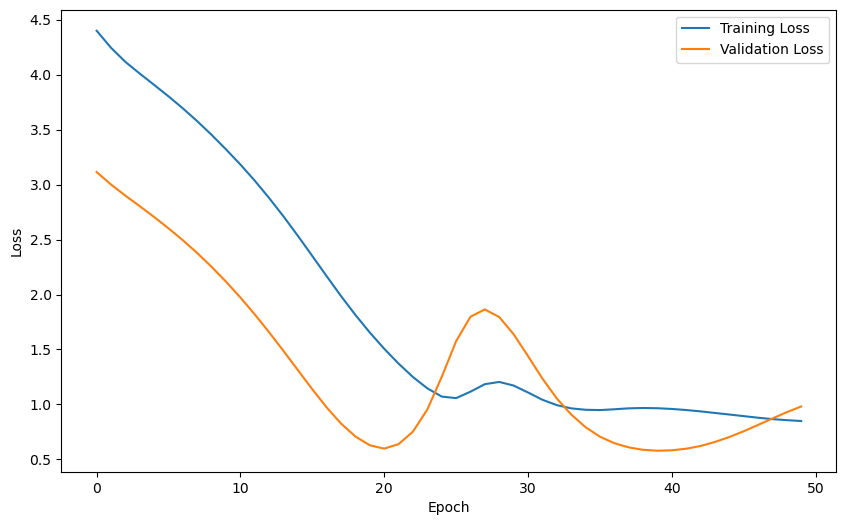

In [81]:
df['arrival_time'] = pd.to_datetime(df['arrival_time']).apply(lambda x: x.timestamp()) 

# Define your sequence length (number of time steps per sequence)
sequence_length = 10

# Select relevant features (including 'arrival_time')
selected_features = ['arrival_time', 'stop_lat', 'stop_lon', 'speed_kmh', 'segment_max_speed_kmh', 'runtime_sec']

# Normalize the selected features
scaler = StandardScaler()
df[selected_features[1:]] = scaler.fit_transform(df[selected_features[1:]])

# Create sequences of data
def create_sequences(df, sequence_length):
    sequences = []
    for i in range(len(df) - sequence_length + 1):
        sequence = df.iloc[i:i + sequence_length]
        sequences.append(sequence.values)
    return np.array(sequences)

# Create sequences for training
sequences = create_sequences(df[selected_features], sequence_length)

# Define target variable
target = df['congestion_level'].values[sequence_length - 1:]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, target, test_size=0.2, random_state=42)

# Build the LSTM model
model = keras.Sequential([
    keras.layers.LSTM(64, input_shape=(sequence_length, len(selected_features)), return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()